<a href="https://colab.research.google.com/github/rajlm10/D2L-Torch/blob/main/D2L_Attention_Mechanisms.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install d2l

In [2]:
import math
import torch
from torch import nn
from d2l import torch as d2l

In [3]:
def sequence_mask(X,valid_len,fill_value=0):
  """Mask irrelevant entries in sequences."""
  #batch_size X num_steps
  maxlen=X.size(1)
  #Here torch.arange((maxlen)) becomes 1 X num_steps and valid_len becomes batch_size X 1
  #Comparing both after broadcasting we get batch_size X num_steps
  mask=torch.arange((maxlen),dtype=torch.float32,device=X.device)[None, :] < valid_len[:, None]
  X[~mask] = fill_value 
  return X 
 

In [4]:
def masked_softmax(X,valid_lens):
  """Perform softmax operation by masking elements on the last axis."""
  # `X`: 3D tensor, `valid_lens`: 1D or 2D tensor
  if valid_lens is None:
    return nn.functional.softmax(X, dim=-1)

  else:
    shape = X.shape
    if valid_lens.dim() == 1: #(batch_size,)
      valid_lens = torch.repeat_interleave(valid_lens, shape[1]) #batch_size X seq_len
    
    else:
      valid_lens = valid_lens.reshape(-1) #num_examples

    # On the last axis, replace masked elements with a very large negative value, whose exponentiation outputs 0
    X = sequence_mask(X.reshape(-1, shape[-1]), valid_lens,fill_value=-1e6)
    
    return nn.functional.softmax(X.reshape(shape), dim=-1)


In [5]:
masked_softmax(torch.rand(2, 3, 10), torch.tensor([2, 3]))

tensor([[[0.5081, 0.4919, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000],
         [0.4696, 0.5304, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000],
         [0.4927, 0.5073, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000]],

        [[0.2741, 0.2280, 0.4978, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000],
         [0.3867, 0.3903, 0.2230, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000],
         [0.3351, 0.4248, 0.2401, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000]]])

In [6]:
masked_softmax(torch.rand(2, 2, 4), torch.tensor([[1, 3], [2, 4]]))

tensor([[[1.0000, 0.0000, 0.0000, 0.0000],
         [0.4386, 0.2432, 0.3182, 0.0000]],

        [[0.6017, 0.3983, 0.0000, 0.0000],
         [0.2347, 0.2399, 0.3477, 0.1777]]])

# Additive Attention

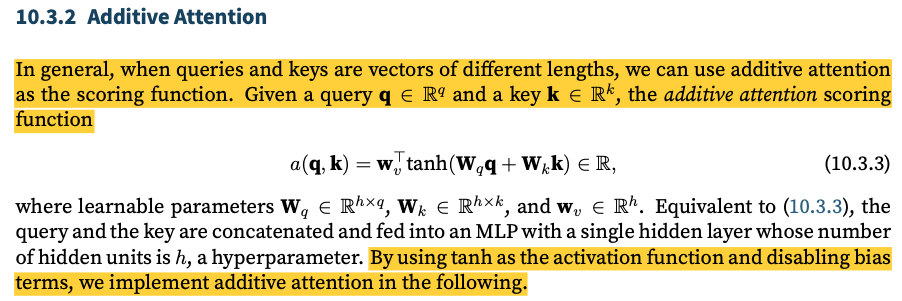

In [7]:
class AdditiveAttention(nn.Module):
  def __init__(self,query_size,key_size,hidden_dims,dropout,**kwargs):
    super(AdditiveAttention,self).__init__(**kwargs)
    self.W_q=nn.Linear(query_size,hidden_dims,bias=False)
    self.W_k=nn.Linear(key_size,hidden_dims,bias=False)
    self.W_v=nn.Linear(hidden_dims,1,bias=False)
    self.dropout = nn.Dropout(dropout)

  def forward(self,queries,keys,values,valid_lens):
    #q-> batch_size X no_of_queries X query_dims
    #k-> batch_size X no_of_keys X key_dims
    #v-> batch_size X no_of_values X value_dims

    queries=self.W_q(queries) #q-> batch_size X no_of_queries X hidden_dims
    keys=self.W_k(keys) #k-> batch_size X no_of_keys X hidden_dims
    features=queries[:,:,None,:]+keys[:,None,:,:]
    features = torch.tanh(features) #batch_size X no_of_queries X no_of_keys X hidden_dims
    scores = self.W_v(features).squeeze(-1) #batch_size X no_of_queries X no_of_keys X 1 (before squeezing)
    self.attention_weights = masked_softmax(scores, valid_lens) #batch_size X no_of_queries X no_of_keys
    
    #Note that no of keys is always equal to no of values
    #batch_size,no_of_queries,no_of_keys X batch_size,no_of_values,value_dims -> batch_size,no_of_queries,value_dims

    return torch.bmm(self.dropout(self.attention_weights), values) 



In [8]:
queries, keys = torch.normal(0, 1, (2, 1, 20)), torch.ones((2, 10, 2))

# The two value matrices in the `values` minibatch are identical

values = torch.arange(40, dtype=torch.float32).reshape(1, 10, 4).repeat(2, 1, 1)
valid_lens = torch.tensor([2, 6])
attention = AdditiveAttention(query_size=20,key_size=2, hidden_dims=8, dropout=0.1)
attention.eval()
attention(queries, keys, values, valid_lens) #batch_size X no_of_queries X value_dims

tensor([[[ 2.0000,  3.0000,  4.0000,  5.0000]],

        [[10.0000, 11.0000, 12.0000, 13.0000]]], grad_fn=<BmmBackward0>)

In [9]:
attention.attention_weights.shape

torch.Size([2, 1, 10])

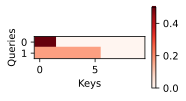

In [10]:
d2l.show_heatmaps(attention.attention_weights.reshape((1, 1, 2, 10)), xlabel='Keys', ylabel='Queries') #

# Scaled-Dot Product Attention

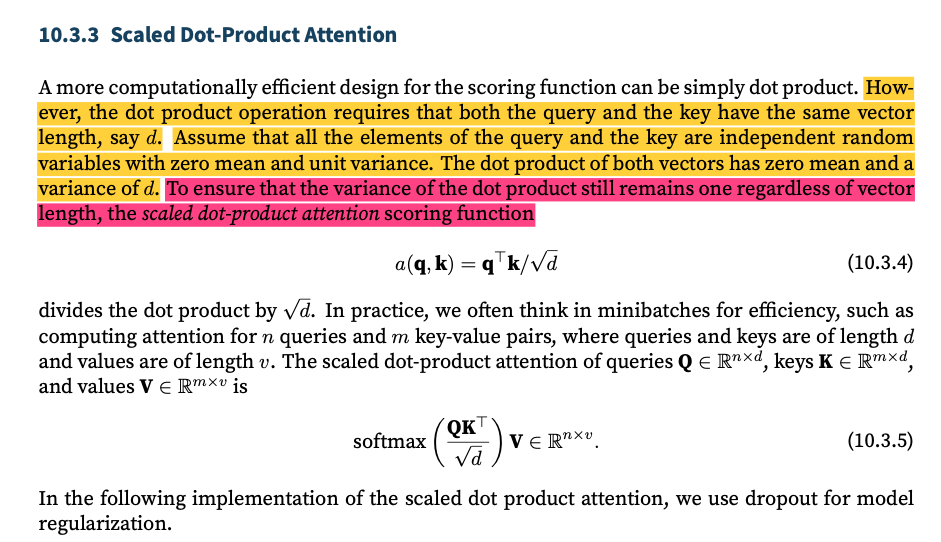

In [11]:
import math
class DotProductAttention(nn.Module):
  def __init__(self,dropout,**kwargs):
    super(DotProductAttention,self).__init__(**kwargs)
    self.dropout=nn.Dropout(dropout)
  
  def forward(self,queries,keys,values,valid_lens=None):
    # Shape of `queries`: (`batch_size`, no. of queries, `d`)
    # Shape of `keys`: (`batch_size`, no. of key-value pairs, `d`)
    # Shape of `values`: (`batch_size`, no. of key-value pairs, value dimension)
    # Shape of `valid_lens`: (`batch_size`,) or (`batch_size`, no. of queries)
    d=queries.shape[-1]
    scores=torch.bmm(queries,keys.permute(0,2,1))/math.sqrt(d) 
    self.attention_weights = masked_softmax(scores, valid_lens) # batch_size X no_queries X no_key_values
    return torch.bmm(self.attention_weights,values) #batch_size X no_queries X value_dims


In [12]:
queries = torch.normal(0, 1, (2, 1, 2)) 
attention = DotProductAttention(dropout=0.5) 
attention.eval()
attention(queries, keys, values, valid_lens)

tensor([[[ 2.0000,  3.0000,  4.0000,  5.0000]],

        [[10.0000, 11.0000, 12.0000, 13.0000]]])

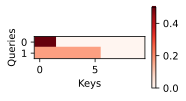

In [13]:
d2l.show_heatmaps(attention.attention_weights.reshape((1, 1, 2, 10)), xlabel='Keys', ylabel='Queries')

# Bahdanau Attention 

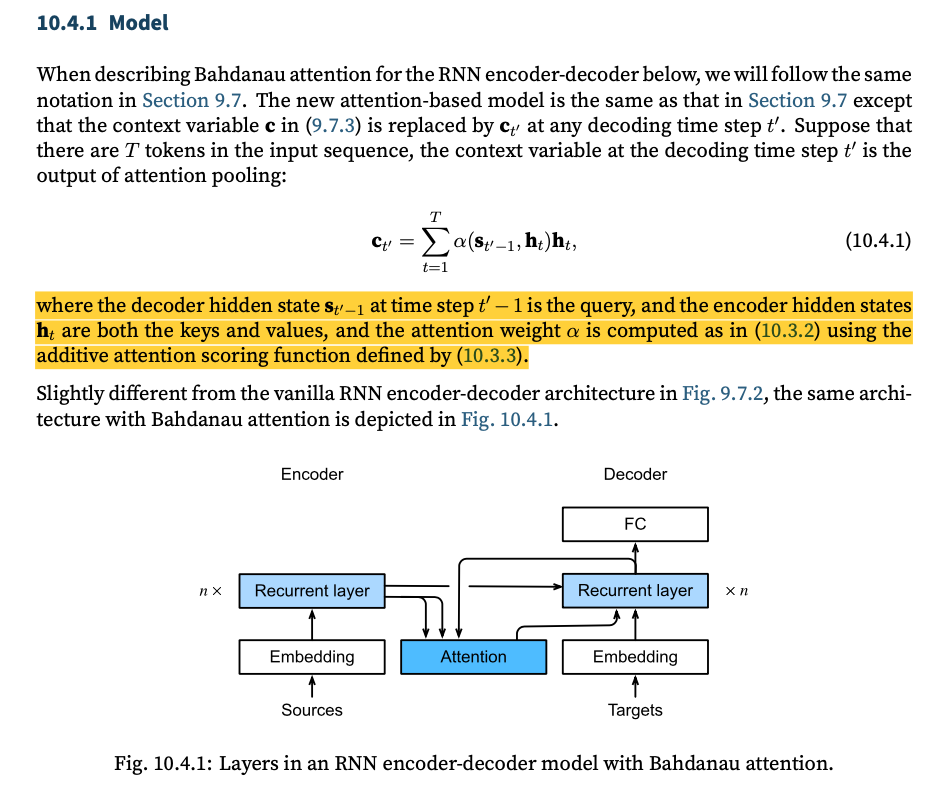

In [14]:
class Seq2SeqEncoder(nn.Module):
  def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,dropout=0, **kwargs):
    super(Seq2SeqEncoder, self).__init__(**kwargs)
    # Embedding layer
    self.embedding = nn.Embedding(vocab_size, embed_size) 
    self.rnn = nn.GRU(embed_size, num_hiddens, num_layers,dropout=dropout)

  def forward(self,X,*args):
    X = self.embedding(X) #batch_size X num_steps X embed_size
    # In RNN models, the first axis corresponds to time steps
    X = X.permute(1, 0, 2) # num_steps X batch_size  X embed_size
    output, state = self.rnn(X) 
    #output-> num_steps X batch_size X num_hiddens
    #state-> num_layers X batch_size X num_hiddens
    return output,state

In [15]:
class Seq2SeqAttentionDecoder(nn.Module):
  def __init__(self,vocab_size, embed_size, num_hiddens, num_layers,dropout=0, **kwargs):
    super(Seq2SeqAttentionDecoder,self).__init__(**kwargs)
    #Queries->prev decoder hidden state i.e (batch_size,1,num_hiddens)
    #Keys & Values-> Encoder final layer hidden_state i.e (num_layers,num_hiddens)
    self.attention = AdditiveAttention(query_size=num_hiddens, key_size=num_hiddens, hidden_dims=num_hiddens, dropout=dropout)
    self.embedding = nn.Embedding(vocab_size, embed_size) 
    self.rnn = nn.GRU(embed_size + num_hiddens, num_hiddens, num_layers,dropout=dropout)
    self.dense = nn.Linear(num_hiddens, vocab_size)

  def init_state(self, enc_outputs, enc_valid_lens, *args):
    outputs, hidden_state = enc_outputs
    #outputs after permuting-> (batch_size,num_steps,num_hiddens) #hidden_state-> (num_layers,batch_size,num_hiddens)
    #enc_valid_lens-> (batch_size,)
    return (outputs.permute(1, 0, 2), hidden_state, enc_valid_lens)
  
  def forward(self,X,state):
    enc_outputs, hidden_state, enc_valid_lens = state
    X = self.embedding(X).permute(1, 0, 2) #num_steps,batch_size,embed_size
    outputs, self._attention_weights = [], []
    for x in X:
      #x is (batch_size,embed_size)
      query=hidden_state[-1][:,None,:] #(batch_size,1,num_hiddens)

      #attention_output is (batch_size,no of queries, value_dims)
      #Thus we get context->(batch_size,1,num_hiddens)
      context=self.attention(query, enc_outputs, enc_outputs, enc_valid_lens)
      x = torch.cat((context, x[:,None,:]), dim=-1) #(batch_size,1,embed_size+num_hiddens)

      out, hidden_state = self.rnn(x.permute(1, 0, 2), hidden_state) #Update decoder hidden state
      outputs.append(out)

      #batch_size X no_of queries X no_of keys
      #That is batch_size X 1 X num_steps
      self._attention_weights.append(self.attention.attention_weights)
    
    # After fully-connected layer transformation, shape of `outputs`: # (`num_steps`, `batch_size`, `vocab_size`)
    outputs = self.dense(torch.cat(outputs, dim=0))
    return outputs.permute(1, 0, 2), [enc_outputs, hidden_state,enc_valid_lens]

  @property
  def attention_weights(self):
    return self._attention_weights

#Outputs returned
''' 1) decoder outputs batch_size,num_steps,vocab_size
    2) 2.1) encoder output batch_size,num_steps,hidden_dims
       2.2) decoder hidden state of final cell, num_layers,batch_size,num_hiddens
       2.3) enc_valid_lens (batch_size,)

'''

In [16]:
#Encoder Decoder
class EncoderDecoder(nn.Module):
  """The base class for the encoder-decoder architecture.""" 
  def __init__(self, encoder, decoder, **kwargs):
    super(EncoderDecoder, self).__init__(**kwargs) 
    self.encoder = encoder
    self.decoder = decoder

  def forward(self, enc_X, dec_X, *args):
    enc_outputs = self.encoder(enc_X, *args)
    dec_state = self.decoder.init_state(enc_outputs, *args) 
    return self.decoder(dec_X, dec_state)

In [17]:
class MaskedSoftmaxCELoss(nn.CrossEntropyLoss):
  """The softmax cross-entropy loss with masks."""
  # `pred` shape: (`batch_size`, `num_steps`, `vocab_size`) 
  # `label` shape: (`batch_size`, `num_steps`)
  # `valid_len` shape: (`batch_size`,)
  def forward(self, pred, label, valid_len):
    weights = torch.ones_like(label) #batch_size X num_steps
    weights = sequence_mask(weights, valid_len) #batch_size X num_steps
    self.reduction='none'
    #y_hat-> batch_size X vocab_size X num_steps, y-> batch_size X num_steps
    #Output-> batch_size X num_steps (since reduction=='none')
    unweighted_loss = super(MaskedSoftmaxCELoss, self).forward(pred.permute(0, 2, 1), label) 
    weighted_loss = (unweighted_loss * weights).mean(dim=1) #batch_size
    return weighted_loss

In [19]:
def grad_clipping(net, theta):
  """Clip the gradient."""
  if isinstance(net, nn.Module):
    params = [p for p in net.parameters() if p.requires_grad] 
  else:
    params = net.params
  norm = torch.sqrt(sum(torch.sum((p.grad ** 2)) for p in params)) 
  if norm > theta:
    for param in params: 
      param.grad[:] *= theta / norm

In [20]:
def train_seq2seq(net, data_iter,loss,optimizer, num_epochs, target_vocab, device):
  def xavier_init_weights(m):
    if type(m) == nn.Linear: 
      nn.init.xavier_uniform_(m.weight)
    if type(m) == nn.GRU:
      for param in m._flat_weights_names:
        if "weight" in param: 
          nn.init.xavier_uniform_(m._parameters[param])
  net.apply(xavier_init_weights)
  net.to(device)
  net.train()
  for epoch in range(num_epochs):
    timer = d2l.Timer()
    metric = d2l.Accumulator(2) # Sum of training loss, no of unmasked tokens
    for batch in data_iter:
      optimizer.zero_grad()
      X, X_valid_len, Y, Y_valid_len = [x.to(device) for x in batch]
      bos = torch.tensor([tgt_vocab['<bos>']] * Y.shape[0],device=device).reshape(-1, 1) # batch_size X 1

      #Y-> batch_size X num_steps
      #dec_input-> batch_size X num_steps (add bos omit eos)
      dec_input = torch.cat([bos, Y[:, :-1]], 1) # Teacher forcing

      Y_hat, _ = net(X, dec_input, X_valid_len)
      l = loss(Y_hat, Y, Y_valid_len)
      #Sum along entire batch
      l.sum().backward() # Make the loss scalar for `backward`
      grad_clipping(net, 1)
      num_tokens = Y_valid_len.sum() #Note how we consider UNMASKED tokens only
      optimizer.step()
      with torch.no_grad():
        metric.add(l.sum(), num_tokens)

    print(f'loss {metric[0] / metric[1]:.3f}, {metric[1] / timer.stop():.1f} ' f'tokens/sec on {str(device)}')

In [21]:
embed_size, num_hiddens, num_layers, dropout = 32, 32, 2, 0.1 
batch_size, num_steps = 64, 10
lr, num_epochs, device = 0.005, 250, d2l.try_gpu()

train_iter, src_vocab, tgt_vocab =d2l.load_data_nmt(batch_size, num_steps)


encoder = Seq2SeqEncoder(len(src_vocab), embed_size, num_hiddens, num_layers, dropout)
decoder = Seq2SeqAttentionDecoder(len(tgt_vocab), embed_size, num_hiddens, num_layers, dropout)
net = EncoderDecoder(encoder, decoder)
loss=MaskedSoftmaxCELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=lr)

In [22]:
train_seq2seq(net, train_iter, loss,optimizer,num_epochs, tgt_vocab, device)

loss 0.474, 4331.6 tokens/sec on cuda:0
loss 0.340, 6913.7 tokens/sec on cuda:0
loss 0.296, 6881.1 tokens/sec on cuda:0
loss 0.275, 6911.6 tokens/sec on cuda:0
loss 0.262, 6435.9 tokens/sec on cuda:0
loss 0.252, 6838.3 tokens/sec on cuda:0
loss 0.243, 6897.0 tokens/sec on cuda:0
loss 0.235, 6970.1 tokens/sec on cuda:0
loss 0.228, 6964.5 tokens/sec on cuda:0
loss 0.220, 6768.2 tokens/sec on cuda:0
loss 0.213, 4545.5 tokens/sec on cuda:0
loss 0.205, 6830.7 tokens/sec on cuda:0
loss 0.197, 6760.2 tokens/sec on cuda:0
loss 0.190, 6818.3 tokens/sec on cuda:0
loss 0.183, 6834.5 tokens/sec on cuda:0
loss 0.177, 6921.4 tokens/sec on cuda:0
loss 0.171, 7112.6 tokens/sec on cuda:0
loss 0.165, 7023.8 tokens/sec on cuda:0
loss 0.158, 6511.2 tokens/sec on cuda:0
loss 0.153, 6779.8 tokens/sec on cuda:0
loss 0.147, 6696.9 tokens/sec on cuda:0
loss 0.142, 6941.6 tokens/sec on cuda:0
loss 0.137, 6921.4 tokens/sec on cuda:0
loss 0.132, 6736.7 tokens/sec on cuda:0
loss 0.128, 6757.0 tokens/sec on cuda:0


In [25]:
engs = ['go .', "i lost .", 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .'] 

for eng, fra in zip(engs, fras):
  translation, dec_attention_weight_seq = d2l.predict_seq2seq( net, eng, src_vocab, tgt_vocab, num_steps, device, True)
  print(f'{eng} => {translation}, ',f'bleu {d2l.bleu(translation, fra, k=2):.3f}')

go . => va !,  bleu 1.000
i lost . => j'ai perdu .,  bleu 1.000
he's calm . => il court .,  bleu 0.000
i'm home . => je suis chez moi .,  bleu 1.000
